# Imports: 

In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

import sklearn
import xgboost

In [3]:
cols = sns.color_palette("tab10")

# Load files:

Classification into substrates: 

In [80]:
fn = '../data/tests/df_hub_metabolites.csv'
df_class = pd.read_csv(fn)

# df_y.loc[df_y.Rv_ID == 'Rv3423', 'Rv_ID'] = 'Rv3423c'
df_class.loc[df_class.Rv_ID == 'Rv2922', 'Rv_ID'] = 'Rv2922A'

df_class.shape

(860, 30)

TnSeq database: 

In [116]:
# version = 'old'
version = 'clare_basis'
# version = 'clare_all'

# if version == 'old':
#     fn = 'lfc_mb_filt_OLD.csv' ## data set without Claire's screens
# elif version == 'clare_all':
#     fn = 'lfc_mb_filt.csv' ## data set with all of Claire's pairwise combinations
if version == 'clare_basis':
    fn = 'result_logfc_matrix_2021_08_27_BASIS.csv' ## data set only Claire's mutant vs. wildtype screens

path = '../data/standardized_data/'
df_lfc = pd.read_csv(os.path.join(path, fn))
df_lfc.dropna(axis = 0, inplace=True)

df_lfc.shape

(3971, 126)

# Train classifier: 

### Prepare X and y arrays:

X

In [117]:
df_lfc_train = df_lfc[df_lfc.Rv_ID.isin(df_class.Rv_ID)].copy()
df_lfc_train.reset_index(inplace = True, drop = True)

cols_data = df_lfc_train.columns[1:-1]
X = df_lfc_train[cols_data].to_numpy()

X.shape

(857, 124)

y

In [118]:
cols_chebi = [col for col in df_class.columns if 'CHEBI' in col]
df_y = df_lfc_train[['Rv_ID']].merge(df_class, on = 'Rv_ID', how = 'left')[['Rv_ID']+cols_chebi].copy()
print(df_y.Rv_ID.tolist() == df_lfc_train.Rv_ID.tolist())
print(df_y.shape)
df_y.head(2)

True
(857, 16)


,Rv_ID,CHEBI_30616,CHEBI_43474,CHEBI_33019,CHEBI_456216,CHEBI_57287,CHEBI_57540,CHEBI_456215,CHEBI_57945,CHEBI_16526,CHEBI_57783,CHEBI_58349,CHEBI_29985,CHEBI_30616-OR-CHEBI_456216-OR-CHEBI_456215,CHEBI_57540-OR-CHEBI_57945-OR-CHEBI_57783-OR-CHEBI_58349,CHEBI_43474-OR-CHEBI_33019
0,Rv0009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Rv0013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [130]:
def classifier(X, y, model, shuffle):

    n_splits = 5
    n_classes = 2
    list_roc_auc = [] # store median roc_auc for each regularization parameter
    
    if model == 'logreg':
        reg_param_list = np.array([1e-2, 1e-1, 1e0, 1e1]) # l1 regularization
    elif model == 'xgbc':
        reg_param_list = np.array([10, 100])
    
    # shuffle or don't shuffle y
    y_shfl = y.copy()
    if shuffle: 
        random.shuffle(y_shfl)

    for reg_param_temp in reg_param_list:   # For each regularization parameter: 
        roc_auc = [] #store auc_roc for each fold

        if model == 'logreg':
            clf = LogisticRegression(penalty='l1', solver='liblinear', C=reg_param_temp) # you don't need the multiclass
            # clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=reg_param_temp)
        elif model == 'xgbc':
            clf = XGBClassifier(gamma = reg_param_temp, reg_alpha=1, reg_lambda=1, eval_metric='logloss', use_label_encoder=False)

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y_shfl[train_index], y_shfl[test_index]
            X_train, y_train = SMOTE().fit_resample(X_train, y_train) # understand this step. 
            # fit model
            clf.fit(X_train, y_train)
            # predict on test set
            y_hat = clf.predict(X_test)
            # evalute classification score using AU-ROC   
            y_pred = clf.predict_proba(X_test)
            roc_auc.append(roc_auc_score(y_test, y_pred[:, 1]))

        list_roc_auc.append( np.median(roc_auc) )
        
            
    df_accuracy = pd.DataFrame()
    df_accuracy['C_reg'] = reg_param_list
    df_accuracy['roc_auc'] = list_roc_auc

    return df_accuracy

In [164]:
df_true_vs_shlf = pd.DataFrame()
model = 'logreg'
metric = 'roc_auc'

for col in cols_chebi: # For each compound-hub:
    print(col)
    # col = cols_chebi[0]
    # true accuracy
    shuffle = False 
    y = df_y[col].values
    df_accuracy = classifier( X, y, model, shuffle )
    # df_accuracy['compound'] = [col]*df_accuracy.shape[0]
    # df_accuracy = df_accuracy[['compound', 'C_reg', 'roc_auc']]
    # df_accuracy_all = pd.concat([df_accuracy_all, df_accuracy])

    # accuracy after permutation
    shuffle = True 
    num_iter = 5
    list_df_accuracy_SHFL = []

    # col = 'CHEBI_57540-OR-CHEBI_57945-OR-CHEBI_57783-OR-CHEBI_58349'
    for ii in range(num_iter):
        print(ii, 'out of', num_iter)
        df_accuracy_SHFL = classifier(X, y, model, shuffle)
        list_df_accuracy_SHFL.append(df_accuracy_SHFL)

    # Store accuracies of true and shuffled datasets: 
    list_metric_true = []
    list_metric_shfl_pc95 = []
    list_metric_shfl_pc5 = []
    list_metric_shfl_mean = []

    list_C = df_accuracy.C_reg.unique()
    for C in list_C:
        metric_true = df_accuracy[df_accuracy.C_reg==C][metric].values[0]
        list_metric_shfl = [ df[df.C_reg == C][metric].values[0] for df in list_df_accuracy_SHFL ]
        # error bars: 
        metric_shfl_pc95 = np.percentile(list_metric_shfl, 95)
        metric_shfl_pc5 = np.percentile(list_metric_shfl, 5)
        metric_shfl_mean = np.median(list_metric_shfl)
        list_metric_true.append(metric_true)
        list_metric_shfl_pc95.append(metric_shfl_pc95)
        list_metric_shfl_pc5.append(metric_shfl_pc5)
        list_metric_shfl_mean.append(metric_shfl_mean)

    df_true_vs_shfl_temp = pd.DataFrame()
    df_true_vs_shfl_temp['compound'] = [col]*len(list_metric_true)
    df_true_vs_shfl_temp['model'] = [model]*len(list_metric_true)
    df_true_vs_shfl_temp['C_reg'] = list_C
    df_true_vs_shfl_temp['metric_true'] = list_metric_true
    df_true_vs_shfl_temp['metric_shfl_pc95'] = list_metric_shfl_pc95
    df_true_vs_shfl_temp['metric_shfl_pc5'] = list_metric_shfl_pc5
    df_true_vs_shfl_temp['metric_shfl_mean'] = list_metric_shfl_mean

    df_true_vs_shlf = pd.concat([df_true_vs_shlf, df_true_vs_shfl_temp], axis=0)

CHEBI_30616
0 out of 5
1 out of 5
2 out of 5
3 out of 5
4 out of 5
CHEBI_43474
0 out of 5
1 out of 5
2 out of 5
3 out of 5
4 out of 5
CHEBI_33019
0 out of 5
1 out of 5
2 out of 5
3 out of 5
4 out of 5
CHEBI_456216
0 out of 5
1 out of 5
2 out of 5
3 out of 5
4 out of 5
CHEBI_57287
0 out of 5
1 out of 5
2 out of 5
3 out of 5
4 out of 5
CHEBI_57540
0 out of 5
1 out of 5
2 out of 5
3 out of 5
4 out of 5
CHEBI_456215
0 out of 5
1 out of 5
2 out of 5
3 out of 5
4 out of 5
CHEBI_57945
0 out of 5
1 out of 5
2 out of 5
3 out of 5
4 out of 5
CHEBI_16526
0 out of 5
1 out of 5
2 out of 5
3 out of 5
4 out of 5
CHEBI_57783
0 out of 5
1 out of 5
2 out of 5
3 out of 5
4 out of 5
CHEBI_58349
0 out of 5
1 out of 5
2 out of 5
3 out of 5
4 out of 5
CHEBI_29985
0 out of 5
1 out of 5
2 out of 5
3 out of 5
4 out of 5
CHEBI_30616-OR-CHEBI_456216-OR-CHEBI_456215
0 out of 5
1 out of 5
2 out of 5
3 out of 5
4 out of 5
CHEBI_57540-OR-CHEBI_57945-OR-CHEBI_57783-OR-CHEBI_58349
0 out of 5
1 out of 5
2 out of 5
3 out

In [175]:
def plot_real_vs_shuffled_metric_many(df_true_vs_shlf, C, model, cols, xymin = 0.35, xymax = 0.85):

    df_C = df_true_vs_shlf[df_true_vs_shlf.C_reg == C]
    plt.figure(figsize=(7,7))
    plt.scatter(df_C.metric_true, df_C.metric_shfl_mean, color = cols[-3], s=100, edgecolors='k', linewidths=2)
    plt.errorbar(df_C.metric_true, df_C.metric_shfl_mean, 
                 yerr = [df_C.metric_shfl_mean-df_C.metric_shfl_pc5, df_C.metric_shfl_pc95-df_C.metric_shfl_mean], 
                 fmt = '.', markersize=1, capsize=5, ecolor='k')

    xyline = np.linspace(xymin, xymax, 100)
    plt.xlim(xymin, xymax)
    plt.ylim(xymin, xymax)
    plt.plot(xyline, xyline, 'k--')

    plt.title('logistic regression, C = '+str(C), fontsize = 18)
    plt.xlabel('classification score (AU-ROC)', fontsize = 18)
    plt.ylabel('classification score (AU-ROC)\nrandomized', fontsize = 18)

    xt = plt.xticks(fontsize = 14)
    yt = plt.yticks(fontsize = 14)
    plt.tight_layout()
    # save to file: 
#     path_fig = '../figures/Adrian_classification/'
#     fn_fig = 'true_vs_shuffle_MANY'+metric+'_'+model+'_C_'+str(C)+'_'+version+'.png'
#     plt.savefig(os.path.join(path_fig, fn_fig), dpi = 250)

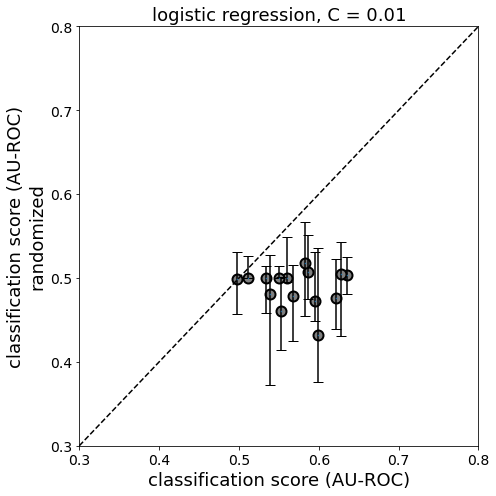

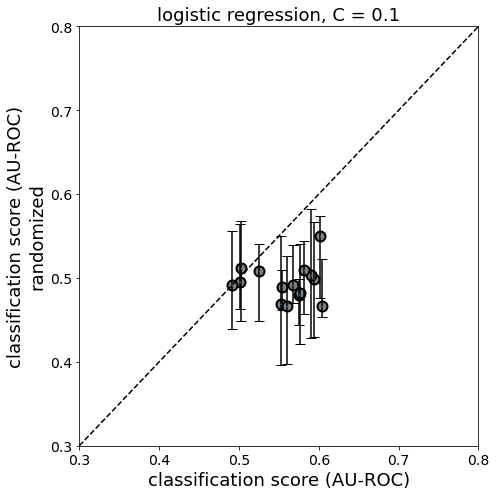

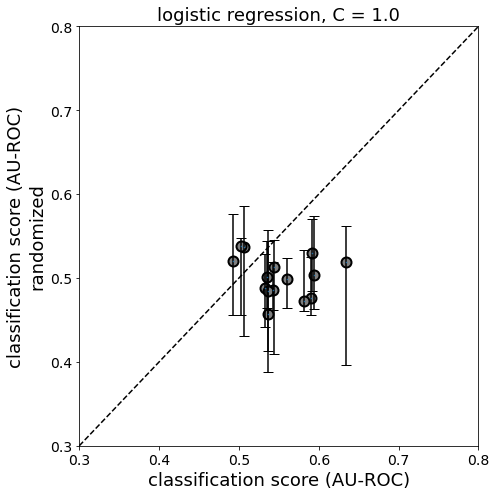

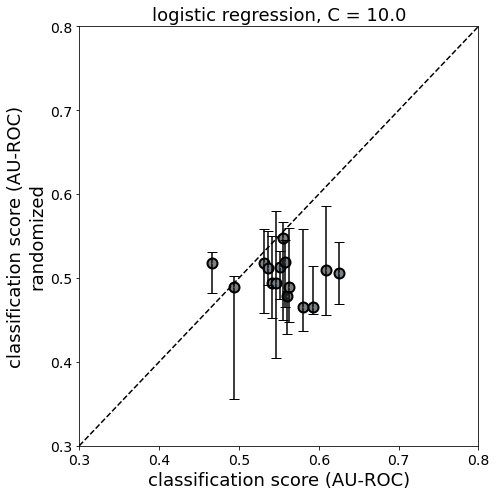

In [176]:
for C in df_true_vs_shlf.C_reg.unique():
    plot_real_vs_shuffled_metric_many(df_true_vs_shlf, C, model, cols, xymin = 0.3, xymax = 0.8)